# PUF model and probability distributions

We use the temperature-dependent model for SRAM-PUF as defined by Roel Maes. 
\begin{align*}
r_i^{(j)}=\left\{\begin{matrix}
0 , &\text{if } m_i+d_i\cdot t^{(j)} +w\leq \tau,\\
1 , &\text{if } m_i+d_i \cdot t^{(j)} +w> \tau.
\end{matrix}\right.
\end{align*}
With process variable $m_i \sim \mathcal{N}(\mu_M,\sigma_M^2)$, temperature dependence variable $d_i \sim \mathcal{N}(0,\sigma_D^2)$, noise variable $w_i^{(j)} \sim \mathcal{N}(0,\sigma_N^2)$, and temperature $t^{(j)}$ at time $j$.
Roel also defines some parameters $\lambda_1 = \sigma_N/\sigma_M$, $\lambda_2 = (\tau-\mu_M)/\sigma_M$, and $\theta= \sigma_N / \sigma_D $. 

We refer to the one-probability of cell $i$ as $\xi_i$ and in case of known state-variables, this is given as $\xi_i = \Pr(X=1) = 1- cdf_N(\tau - m_i-d_i \cdot t^{(j)} )=\Phi(\frac{-\tau + m_i + d_i \cdot t^{(j)} }{\sigma_N}) $.

It is our goal to estimate $\lambda_1,\lambda_2,\theta$ for our dataset.

We will use maximum-likelihood estimation to achieve this.

## Settings of parameters

In [69]:
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt
import srampufparest
# set the parameters
lambda12 = [0.1212,-0.0005] # settings from Roel: 0.1213,0.021,45
theta = 45;

# verify srampufparest.loadUnique()
Does it give the same histogram as the code that I used before ?

In [2]:
Nsamples = 60
Ndevices = 96
datapath = r'C:\Users\lkusters\surfdrive\python\server_008104\20181125\Unique'
folder = datapath+'\\002_Temp_025'
_,merged2 = srampufparest.loadUnique(folder)
import os
data25 = [[] for i in range(Nsamples)]
for ii in range(Ndevices):
    count = 0;
    for fname in os.listdir(folder):
        if fname.startswith("Unique_dev%03d"%(ii+1) ):
            data =  np.fromfile(folder+'\\'+fname, np.uint8) 
            data_bits = np.unpackbits(data)
            data25[count].extend(data_bits)
            count += 1;
data25 = np.swapaxes(data25,0,1) # swap axes, s.t. 1st dim is cells, and second is observations
folder = datapath+'\\001_Temp_m40'
_,merged1 = srampufparest.loadUnique(folder)

Finished loading data for 96 devices, with 60 observations of 65536 cells
returning observations [96,60,65536] and merged observations [6291456,60]
Finished loading data for 96 devices, with 40 observations of 65536 cells
returning observations [96,40,65536] and merged observations [6291456,40]


In [12]:
mse = 0
for rowd,rowm in zip(data25,merged2):
    # compare the rows
    mse = mse+sum([(i-j)**2 for i,j in zip(rowd,rowm)])
print('load data: MSE(old method,new method) = %0.4f'%mse)

0


In [10]:
# from srampufparest
from numpy.random import uniform
print(len(merged2))
N25 = [len(d) for d in merged2] # number of measurements per cell
sums25 = [sum(n) for n in merged2 ]
print(set(N25))
# now generate errorcount
errorcount25 = [sum25 if uniform(0,1,1)>(sum25/Nsamples) else Nsamples-sum25 for sum25 in sums25]

6291456
{60}


In [15]:
# original method
from numpy.random import uniform
print(len(data25))
N25 = [len(d) for d in data25] # number of measurements per cell
sums25 = [sum(n) for n in data25 ]
print(set(N25))
# now generate errorcount
errorcount25 = [sum25 if uniform(0,1,1)>(sum25/Nsamples) else Nsamples-sum25 for sum25 in sums25]

6291456
{60}


Finished generating histogram, with 60 max observations and 6291456 total cells


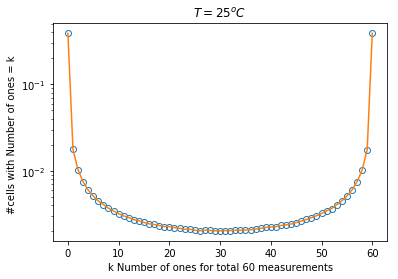

In [17]:
# ORIGINAL
# plot the histogram of the number of observed ones in each cell
from scipy.special import comb
pmfdata_sum25,edges = np.histogram(sums25,bins=Nsamples+1,range=(-.5,Nsamples+.5))
plt.plot(range(Nsamples+1),[count/len(data25) for count in pmfdata_sum25] ,'o', fillstyle='none')
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.title('$T=25^oC$')

# Functions srampuf
pmfhist,centers = srampufparest.getcounts1D(merged2)
plt.plot(centers,[count/len(merged1) for count in pmfhist] )

plt.show()

In [19]:
mse = 0
mse = mse+sum([(i-j)**2 for i,j in zip(pmfdata_sum25,pmfhist)])
print('find histogram k-ones: MSE(old method,new method) = %0.4f'%mse)

0


# Verify fitting method

# Pdf of one-probability (no temperature)

We find that apparently the approximations by python (in integrator?) are not accurate enough, since the pdf does not sum to 1 (but instead 0.38). Therefore, we instead use the equations to approximate the cdf and then calculate the pdf by integrating (sum over small intervals). 

## Pdf of the one-probability
\begin{equation}
        p_0(\xi|\lambda_1,\lambda_2)
        = \frac{\lambda_1 \cdot \phi( \Phi^{-1}(\xi) \cdot \lambda_1  +\lambda_2) }{\phi(\Phi^{-1}(\xi))}
\end{equation}

First, we show that indeed the total probability does not sum to 1:

## Cdf of the one-probability


The PDF can be approximated as 
\begin{equation}
        p_0(\xi|\lambda_1,\lambda_2)
        = \Pr(\Xi \leq \xi + \Delta\xi) - \Pr(\Xi \leq \xi - \Delta\xi) ,
\end{equation}
with 
\begin{equation}
        \Pr(\Xi \leq \xi)
        = \Phi( \Phi^{-1}(\xi) \cdot \lambda_1  +\lambda_2) 
\end{equation}

Second show that we can use cdf and integrate to improve the approximation

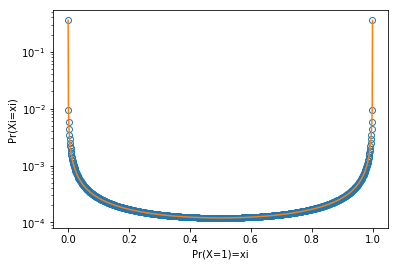

1.0 should be equal to ONE 


In [34]:
# First plot the pdf
l1 = lambda12[0]
l2 = lambda12[1]
NX = 1000 # number of steps

xx = [i for i in np.linspace(0,1,NX)]
yy= [norm.cdf(l1*norm.ppf(xi)+l2) for xi in xx]
pdf_one = np.diff(yy)
pdf_x = [x+0.5/NX for x in xx[:-1]]
plt.plot(pdf_x,pdf_one,'o', fillstyle='none')

NX = 1000 # number of steps

p0_p, p0_xi = srampufparest.pdfp0(l1,l2,NX) 

plt.plot(p0_xi,p0_p)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi)')
plt.show()
pred = sum(p0_p) # should be 1
print(pred, 'should be equal to ONE ')

Finished generating histogram, with 60 max observations and 6291456 total cells


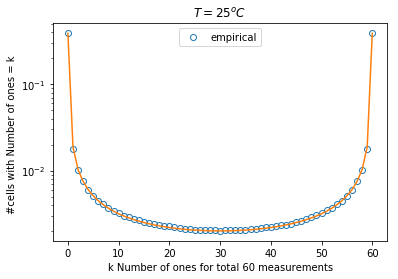

Area under curve = 1.000000 (should be equal to 1) 
\lambda_1 = 0.1212, \lambda_2 = -0.0005
pdf of k-ones: MSE(empricial,predicted) = 0.000003


In [70]:
# Then verify that we can reproduce the histogram of the one counts
# plot the histogram of the number of observed ones in each cell
from scipy.special import comb
pmfhist,centers = srampufparest.getcounts1D(merged2)
plt.plot(centers,[count/len(merged1) for count in pmfhist] ,'o', fillstyle='none')
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.title('$T=25^oC$')
# Now the fit
l1 = lambda12[0]
l2 = lambda12[1]
NX = 10000 # number of steps

pmf_pred, pmf_pred_xi = srampufparest.pmfpkones(NX, l1, l2, 60) 
        
plt.plot(pmf_pred_xi,pmf_pred)
plt.legend(['empirical','prediction'])
plt.show()
pred = sum(p0_p) # should be 1
print('Area under curve = %0.6f (should be equal to 1) '%pred)
print('\lambda_1 = %0.4f, \lambda_2 = %0.4f'%(l1,l2))

pmf_emp = [count/len(merged1) for count in pmfhist]
MSE = sum([(x-y)**2 for (x,y) in zip(pmf_emp,pmf_pred)])
print('pdf of k-ones: MSE(empricial,predicted) = %0.6f'%MSE)

# Pdf of one-probability (with temperature)


## Pdf of the one-probability
\begin{equation}
        p_1(\xi_2|\xi_1,t_1,t_2,\lambda_1,\lambda_2,\theta)
        = \phi \left(\frac{\theta}{t_2-t_1} \cdot (\Phi^{-1}(\xi_{t_2})-\Phi^{-1}(\xi_{t_1})) \right)   \cdot \frac{\theta}{t_2-t_1}  \cdot  \frac{1 }{\phi(\Phi^{-1}(\xi_{t_2} )  ) }
\end{equation}

First, we show that indeed the total probability does not sum to 1:

## Cdf of the one-probability


The PDF can be approximated as 
\begin{equation}
        p_1(\xi_2|\xi_1,t_1,t_2,\lambda_1,\lambda_2,\theta)
        = \Pr(\Xi_{t_2} \leq \xi_{t_2}+ \Delta\xi|\Xi_{t_1}=\xi_{t_1})  - \Pr(\Xi_{t_2} \leq \xi_{t_2}- \Delta\xi|\Xi_{t_1}=\xi_{t_1}) ,
\end{equation}
with 
\begin{equation}
        \Pr(\Xi_{t_2} \leq \xi_{t_2}|\Xi_{t_1}=\xi_{t_1}) 
        = \Phi \left(\frac{\theta}{t_2-t_1} \cdot (\Phi^{-1}(\xi_{t_2})-\Phi^{-1}(\xi_{t_1})) \right)
\end{equation}

We show that we can use cdf and integrate to improve the approximation

Finished generating histogram, with 40 max observations and 32157 total cells


Text(0,0.5,'#cells with Number of ones = k ')

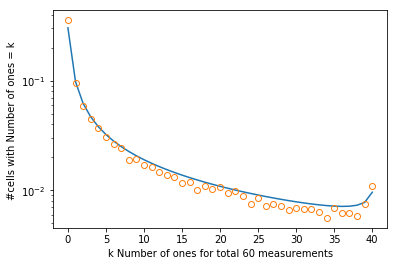

In [4]:
# Now the temperature dependent behavior
# settings from Roel: 0.12,0.02,45
l1 = 0.12
l2 = 0.02
theta = 45
NX = 1000 # number of steps

idx = srampufparest.getcellskones(merged2,5); # select cells that observed 5 ones in T2
merged1_sel = [merged1[i] for i in idx] # find observations of these cells at T1
hist,centerpoints = srampufparest.getcounts1D(merged1_sel); # generate the histogram

p1 = 5/60 # one probability
L = 40 # number of observations at T1
dT = 65 # temperature difference between T1 and T2
predict,x = srampufparest.pmfpkones_temperature(NX,dT,l1,l2,theta,p1,L); # predict the histogram

plt.plot(x,predict)
plt.plot(centerpoints,[h/sum(hist) for h in hist],'o', fillstyle='none') # actual values
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.show()

# REPEAT FOR DIFFERENT init
p1 = 10/60 # one probability
predict,x = srampufparest.pmfpkones_temperature(NX,dT,l1,l2,theta,p1,L); # predict the histogram

plt.plot(x,predict)
plt.plot(centerpoints,[h/sum(hist) for h in hist],'o', fillstyle='none') # actual values
plt.yscale('log')
plt.xlabel('k Number of ones for total %d measurements'%(Nsamples))
plt.ylabel('#cells with Number of ones = k ')
plt.show()

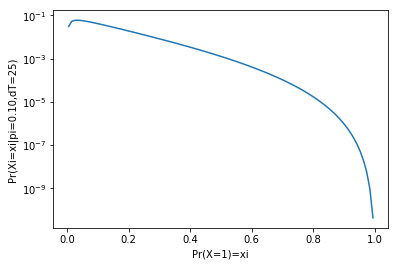

1.0 should be equal to ONE 


In [7]:
# use the CDF
l1 = lambda12[0]
l2 = lambda12[1]
th = theta
NX = 100 # number of steps

dT = 25 # temperature difference

# first we choose single value for pi
pi = 0.1 # xit1
p1_p, p1_xi = srampufparest.pdfp1(pi,dT,l1,l2,th,NX)
plt.plot(p1_xi,p1_p)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi|pi=%0.2f,dT=%d)'%(pi,dT))
plt.show()
pred = sum(p1_p)
xx[0]

print(pred, 'should be equal to ONE ')

# second we integrate over all possible pi, to get the average distribution
# NOT IMPLEMENTED YET FOR NEW METHOD
# we re-use p0_p and p0_xi
ytotal = [ sum( [ Pdfpi*norm.cdf( (th/dT) * (norm.ppf(xi)-norm.ppf(pi)) )  for (Pdfpi,pi) in zip(p0_p,p0_xi) ])   for xi in xx]
ytotal = np.diff(ytotal)
ytotalx = [x+0.5/NX for x in xx[:-1]]

plt.plot(ytotalx,ytotal)
plt.yscale('log')
plt.xlabel('Pr(X=1)=xi')
plt.ylabel('Pr(Xi=xi|dT=%d)'%dT)
plt.show()
pred = sum(ytotal)

print(pred, 'should be equal to ONE ')


# Compare the ML estimation

Compare old ML estimation method with new method from srampufparest module.

In [31]:
# from the old method
import numpy as np
from scipy.stats import norm 
from scipy.special import comb
def calculatePmf_kones_noT(l12,nsamples,NX): # USED for ML estimation without temperature
    # pmf of sum(x)
    # parameters l12 = lambda1, lambda2
    # nsamples is total number of samples
    # out: probability distribution of k (# ones)
    #NX precision of the integrator
    pmf_ones = [];
    l1 = l12[0];l2=l12[1];
    # now the integrator
    xx = [i for i in np.linspace(0,1,NX)]
    yy= [norm.cdf(l1*norm.ppf(xi)+l2) for xi in xx]
    pdfpx = [xi+0.5/NX for xi in xx[:-1]]
    pdfpy = np.diff(yy)
    
    for nones in range(nsamples+1): # loop over number of ones
        pred = [(xi**nones)*((1-xi)**(nsamples-nones))*pdfp for (xi,pdfp) in zip(pdfpx,pdfpy) ]
        pmf_ones.append(sum(pred))
    return pmf_ones

In [23]:
# load the data
import srampufparest
datapath = r'C:\Users\lkusters\surfdrive\python\server_008104\20181125\Unique'
folder = datapath+'\\002_Temp_025'
_,merged2 = srampufparest.loadUnique(folder)
pmfhist,centers = srampufparest.getcounts1D(merged2)

Finished loading data for 96 devices, with 60 observations of 65536 cells
returning observations [96,60,65536] and merged observations [6291456,60]
Finished generating histogram, with 60 max observations and 6291456 total cells


In [24]:
#Make the grid
import numpy as np
nl1 = 18;
nl2 = 61;
ll1 = np.linspace(0.118,0.125,nl1);
ll2 = np.linspace(-0.01,0.005,nl2);

Nsamples = 60;
NX = 10000;

In [27]:
LL_old = [[0  for j in range(len(ll2))] for i in range(nl1)]
LL_new = [[0  for j in range(len(ll2))] for i in range(nl1)]
i=0;
for i in range(len(ll1)):
    print(i)
    l1 = ll1[i]
    for j in range(len(ll2)):
        l2 = ll2[j];
        LLloop_old = 0;
        p_k = calculatePmf_kones_noT([l1,l2],Nsamples,NX)
        for (pk,nk) in zip(p_k,pmfhist):
            LLloop_old += nk*np.log10(pk)
        LL_old[i][j] = LLloop_old;
        LL_new[i][j] = srampufparest.loglikelihood(pmfhist,centers,NX, l1, l2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


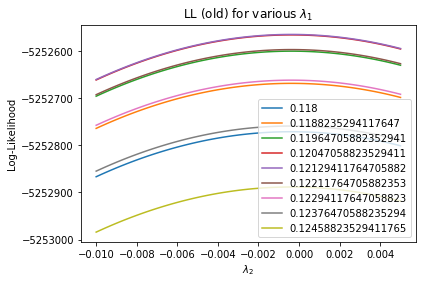

In [29]:
import matplotlib.pyplot as plt
legenda = ()
for i in range(0,len(ll1),2):
    plt.plot(ll2,LL_old[i]);
    legenda = legenda + (str(ll1[i]),);

plt.ylabel('Log-Likelihood')
plt.xlabel('$\lambda_2$')
plt.title('LL (old) for various $\lambda_1$')
plt.legend(legenda)
plt.show()

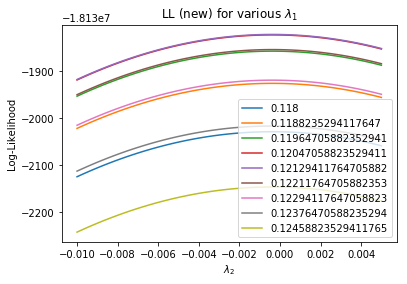

In [30]:
import matplotlib.pyplot as plt
legenda = ()
for i in range(0,len(ll1),2):
    plt.plot(ll2,LL_new[i]);
    legenda = legenda + (str(ll1[i]),);

plt.ylabel('Log-Likelihood')
plt.xlabel('$\lambda_2$')
plt.title('LL (new) for various $\lambda_1$')
plt.legend(legenda)
plt.show()

In [33]:
l1 = 0.12
l2 = -0.001
LLloop_old = 0;
p_k = calculatePmf_kones_noT([l1,l2],Nsamples,NX)
for (pk,nk) in zip(p_k,pmfhist):
    LLloop_old += nk*np.log10(pk)
compare = srampufparest.loglikelihood(pmfhist,centers,NX, l1, l2)
print(compare)
print(LLloop_old)

-18131839.446644746
-18131839.446644746


In [53]:
#Make the grid
import numpy as np
nl1 = 6;
nl2 = 21;
ll1 = np.linspace(0.118,0.122,nl1);
ll2 = np.linspace(-0.005,0.005,nl2);

Nsamples = 60;
NX = 10000;

In [54]:
LL_old2 = [[0  for j in range(len(ll2))] for i in range(nl1)]
LL_new2 = [[0  for j in range(len(ll2))] for i in range(nl1)]
i=0;
for i in range(len(ll1)):
    print(i)
    l1 = ll1[i]
    for j in range(len(ll2)):
        l2 = ll2[j];
        LLloop_old = 0;
        p_k = calculatePmf_kones_noT([l1,l2],Nsamples,NX)
        for (pk,nk) in zip(p_k,pmfhist):
            LLloop_old += nk*np.log10(pk)
        LL_old2[i][j] = LLloop_old;
        LL_new2[i][j] = srampufparest.loglikelihood(pmfhist,centers,NX, l1, l2)

0
1
2
3
4
5


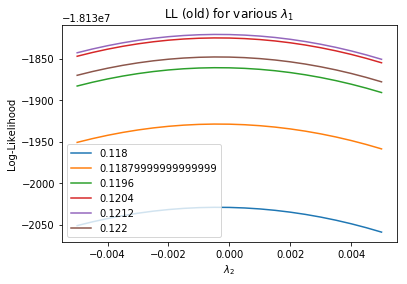

In [55]:
import matplotlib.pyplot as plt
legenda = ()
for i in range(0,len(ll1)):
    plt.plot(ll2,LL_old2[i]);
    legenda = legenda + (str(ll1[i]),);

plt.ylabel('Log-Likelihood')
plt.xlabel('$\lambda_2$')
plt.title('LL (old) for various $\lambda_1$')
plt.legend(legenda)
plt.show()

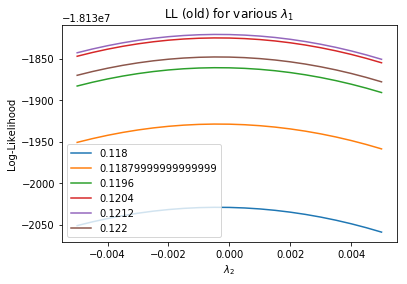

In [56]:
import matplotlib.pyplot as plt
legenda = ()
for i in range(0,len(ll1)):
    plt.plot(ll2,LL_new2[i]);
    legenda = legenda + (str(ll1[i]),);

plt.ylabel('Log-Likelihood')
plt.xlabel('$\lambda_2$')
plt.title('LL (old) for various $\lambda_1$')
plt.legend(legenda)
plt.show()

In [ ]:
LL_new3 = srampufparest.looploglikelihood(pmfhist,centers,NX, ll1, ll2)

In [61]:
print('pdf of k-ones: MSE(empricial,predicted) = %0.6f'%MSE)

pdf of k-ones: MSE(empricial,predicted) = 0.000003
